In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization

## Viewing Static XES Spectra

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfx100894224',lcls_run=24)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['tt/fltpos_ps','epics/lxt', 'scan/mfx_lxt_fast1' , 'MfxDg2BmMon/totalIntensityJoules','tt/ampl'] 
names=['time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl']
#Here we define the epix detector keys separately as they are imported separately to avoid OOM
xes.key_epix=['epix100/ROI_area']
xes.friendly_name_epix=['epix']
##
xes.set_key_aliases(keys,names)
#xes.end_index=5000
xes.mintime=-87E-12
xes.maxtime=-85E-12
xes.numpoints=100
xes.time_bins=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
#xes.rois=[[0,50]]
xes.adu_cutoff=3.0
#xes.angle=90
xes.lxt_key=None
xes.transpose=False
#xes.add_filter('xray','ipm4',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
#xes.add_filter('simultaneous','time_tool_ampl',0.05)
xes.run_parser(['23'])

In [3]:
start=time.time()
xes.primary_analysis_parallel_range(8,xes_experiment,increment=1000,verbose=False)
end=time.time()

Processing: 100%|██████████| 13/13 [00:03<00:00,  3.29Shot_Batch/s]


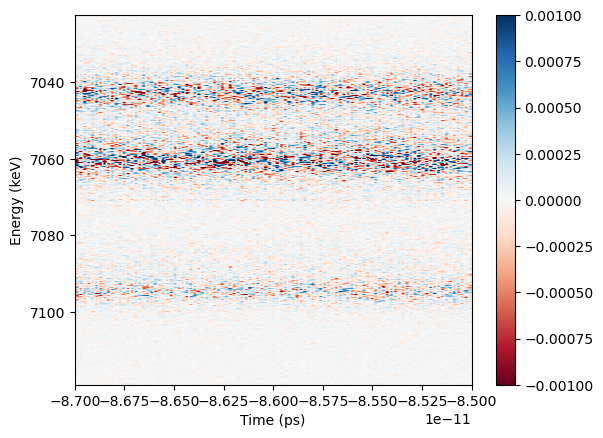

In [4]:
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
v.vmin=-0.001
v.vmax=0.001
v.plot_2d_difference_spectrum(xes)
#plt.xlim(-0.8,0.8)


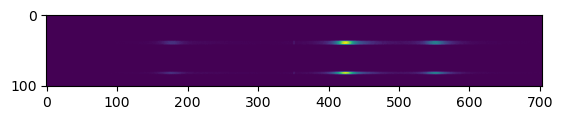

In [5]:
plt.imshow(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1-xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1)

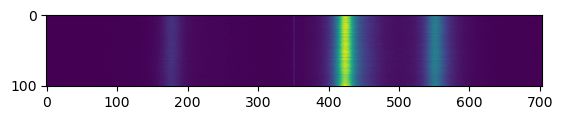

In [6]:
plt.imshow(v.summed_laser_on-v.summed_laser_off)